# SETUP

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

# 1. SETUP TRANSFORMS
# Flowers can be different sizes, so we resize to 224x224 for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Downloading Flowers-102...")

# 2. DOWNLOAD & MERGE ALL DATA
train_part = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_part = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_part = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

full_dataset = ConcatDataset([train_part, val_part, test_part])
total_size = len(full_dataset) # 8,189 images


# 3. 80/10/10 SPLIT
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# 4. DATA LOADERS
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Flowers-102 Ready!")
print(f"Total Images: {total_size}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Flowers-102 Ready!
Total Images: 8189
Train: 6551 | Val: 818 | Test: 820


# LEVEL 1: BASELINE MODEL (ResNet50)

Training on: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


Starting Training...
Epoch 1/10 | Loss: 4.3070 | Val Acc: 20.17% | Time: 68s
Epoch 2/10 | Loss: 2.9704 | Val Acc: 58.56% | Time: 71s
Epoch 3/10 | Loss: 1.4304 | Val Acc: 84.96% | Time: 69s
Epoch 4/10 | Loss: 0.6381 | Val Acc: 92.42% | Time: 71s
Epoch 5/10 | Loss: 0.3437 | Val Acc: 94.01% | Time: 69s
Epoch 6/10 | Loss: 0.2125 | Val Acc: 94.87% | Time: 70s
Epoch 7/10 | Loss: 0.1500 | Val Acc: 94.74% | Time: 69s
Epoch 8/10 | Loss: 0.1081 | Val Acc: 95.23% | Time: 70s
Epoch 9/10 | Loss: 0.0824 | Val Acc: 95.35% | Time: 70s
Epoch 10/10 | Loss: 0.0659 | Val Acc: 95.48% | Time: 70s


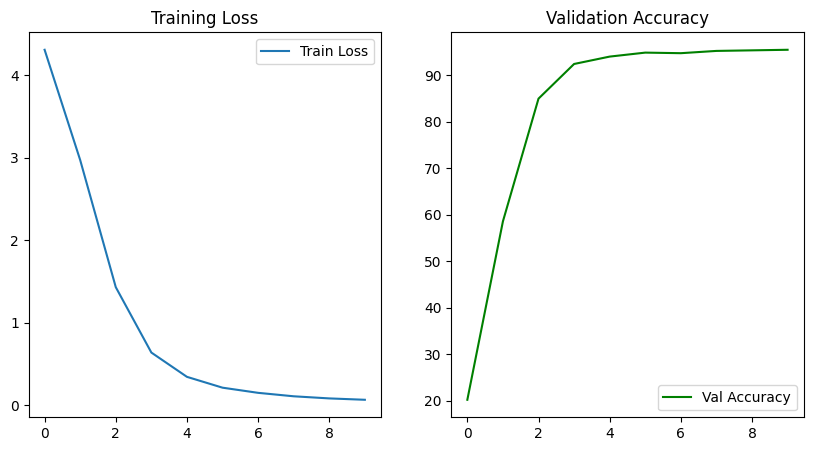

Level 1 Complete & Saved


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# LEVEL 1: BASELINE MODEL (ResNet50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

model = torchvision.models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# TRAINING LOOP
train_losses, val_accs = [], []
num_epochs = 10
print("Starting Training...")

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    dt = time.time() - start
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}% | Time: {dt:.0f}s")

# PLOT & SAVE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='green')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'level_1_flowers.pth')
print("Level 1 Complete & Saved")

# LEVEL 2: Intermediate Techniques (Augmented)

Reloading Data for Level 2...
Level 2 Data Ready!
Training on 6551 Augmented images
Validating on 818 Clean images
Starting Level 2 Training...
Epoch 1/10 | Loss: 4.3609 | Val Acc: 14.43% | Time: 71s
Epoch 2/10 | Loss: 3.0684 | Val Acc: 53.67% | Time: 71s
Epoch 3/10 | Loss: 1.4964 | Val Acc: 81.17% | Time: 72s
Epoch 4/10 | Loss: 0.7370 | Val Acc: 88.88% | Time: 70s
Epoch 5/10 | Loss: 0.4461 | Val Acc: 92.54% | Time: 72s
Epoch 6/10 | Loss: 0.3053 | Val Acc: 93.77% | Time: 71s
Epoch 7/10 | Loss: 0.2353 | Val Acc: 94.87% | Time: 71s
Epoch 8/10 | Loss: 0.1740 | Val Acc: 95.72% | Time: 71s
Epoch 9/10 | Loss: 0.1372 | Val Acc: 95.84% | Time: 71s
Epoch 10/10 | Loss: 0.1135 | Val Acc: 95.72% | Time: 72s


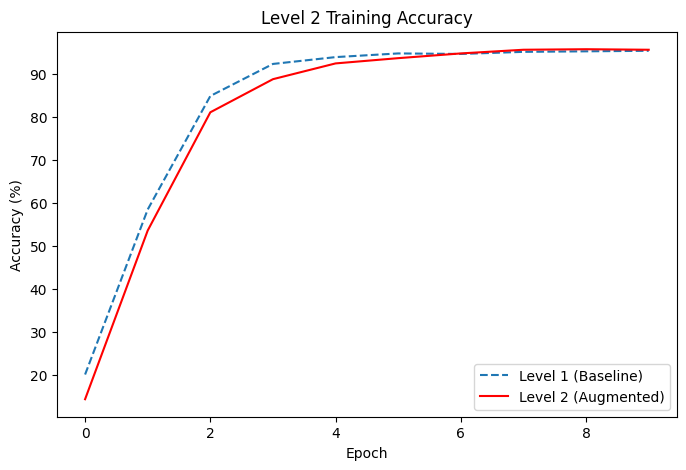

✅ Level 2 Complete & Saved


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import time
import matplotlib.pyplot as plt

# 1. DEFINE TRANSFORMS
# Augmented (For Training)
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Basic (For Validation/Testing - same as Level 1)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Reloading Data for Level 2...")

# 2. LOAD DATA (TWICE)
# Load all 3 official splits with AUGMENTATION
train_aug = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=augment_transform)
val_aug   = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=augment_transform)
test_aug  = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=augment_transform)
full_data_aug = ConcatDataset([train_aug, val_aug, test_aug])

# Load all 3 official splits with BASIC transform (Clean)
train_clean = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=basic_transform)
val_clean   = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=basic_transform)
test_clean  = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=basic_transform)
full_data_clean = ConcatDataset([train_clean, val_clean, test_clean])

# 3. SPLIT (80/10/10)
total_size = len(full_data_aug)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# We use the SAME seed (42) to ensure the split indices are identical
generator = torch.Generator().manual_seed(42)

# Split the Augmented data (We only keep the TRAIN part)
train_dataset_aug, _, _ = random_split(full_data_aug, [train_size, val_size, test_size], generator=generator)

# Split the Clean data (We only keep the VAL and TEST parts)
generator = torch.Generator().manual_seed(42)
_, val_dataset_clean, test_dataset_clean = random_split(full_data_clean, [train_size, val_size, test_size], generator=generator)

# 4. DATALOADERS
train_loader_l2 = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
val_loader_l2   = DataLoader(val_dataset_clean, batch_size=32, shuffle=False, num_workers=2)
test_loader_l2  = DataLoader(test_dataset_clean, batch_size=32, shuffle=False, num_workers=2)

print(f"Level 2 Data Ready!")
print(f"Training on {len(train_dataset_aug)} Augmented images")
print(f"Validating on {len(val_dataset_clean)} Clean images")

# 5. MODEL & TRAINING
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Fresh Model
model_l2 = torchvision.models.resnet50(weights='DEFAULT')
model_l2.fc = nn.Linear(model_l2.fc.in_features, 102)
model_l2 = model_l2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=0.001, momentum=0.9)

print("Starting Level 2 Training...")

# Training Loop
train_losses_l2 = []
val_accs_l2 = []
num_epochs = 10

for epoch in range(num_epochs):
    start = time.time()
    model_l2.train()
    running_loss = 0.0

    for inputs, labels in train_loader_l2:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_l2.zero_grad()
        outputs = model_l2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l2.step()
        running_loss += loss.item() * inputs.size(0)

    # Validation
    model_l2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_l2:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_l2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader_l2.dataset)
    epoch_acc = 100 * correct / total

    train_losses_l2.append(epoch_loss)
    val_accs_l2.append(epoch_acc)

    dt = time.time() - start
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}% | Time: {dt:.0f}s")

# 6. PLOT COMPARISON
plt.figure(figsize=(8, 5))
try:
    plt.plot(val_accs, label='Level 1 (Baseline)', linestyle='--')
except NameError:
    pass # Ignore if Level 1 data is gone
plt.plot(val_accs_l2, label='Level 2 (Augmented)', color='red')
plt.title('Level 2 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

torch.save(model_l2.state_dict(), 'level_2_augmented.pth')
print("✅ Level 2 Complete & Saved")

# LEVEL 3: ADVANCED ARCHITECTURE & EXPLAINABILITY (Grad-CAM)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=b06db57415c998eacb8a2e5f15c6613cb42876585bc20e47cc32404232604c97
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


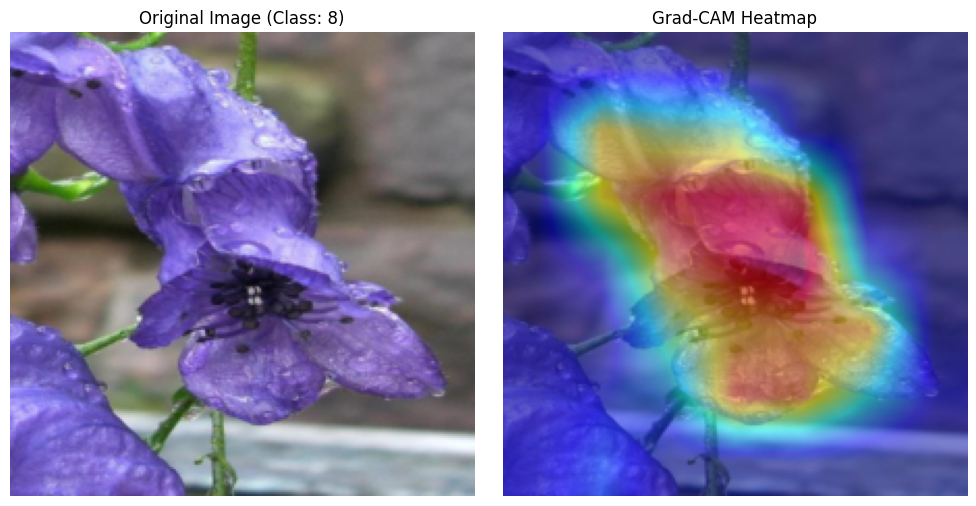

Level 3 Complete: Heatmap Generated


In [ ]:
# 1. INSTALL GRAD-CAM LIBRARY
try:
    from pytorch_grad_cam import GradCAM
except ImportError:
    !pip install grad-cam
    from pytorch_grad_cam import GradCAM

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image

# 2. SELECT A RANDOM IMAGE FROM TEST SET
dataiter = iter(test_loader_l2)
images, labels = next(dataiter)

# Pick the first image in the batch
input_tensor = images[0].unsqueeze(0).to(device)
original_image = images[0].permute(1, 2, 0).cpu().numpy()

# Denormalize (Reverse the math we did earlier so it looks like a normal photo)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_image = std * original_image + mean
original_image = np.clip(original_image, 0, 1)

# 3. INITIALIZE GRAD-CAM
target_layers = [model_l2.layer4[-1]]
cam = GradCAM(model=model_l2, target_layers=target_layers)

# 4. GENERATE HEATMAP
targets = [ClassifierOutputTarget(labels[0].item())]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Overlay heatmap on original image
visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

# 5. DISPLAY RESULTS
plt.figure(figsize=(10, 5))

# Original
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title(f"Original Image (Class: {labels[0].item()})")
plt.axis('off')

# Grad-CAM
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Level 3 Complete: Heatmap Generated")

# LEVEL 4: EXPERT TECHNIQUES (Ensemble Learning)

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

# DEFINING THE TRAINING FUNCTION
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    # We create a fresh optimizer for whatever model is passed in
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_losses, val_accs = [], []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        dt = time.time() - start
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}% | Time: {dt:.0f}s")

    return model, train_losses, val_accs

In [ ]:
# STEP 1: Training Model B (MobileNetV2

# 1. SETUP MOBILENETV2
model_b = torchvision.models.mobilenet_v2(weights='DEFAULT')

model_b.classifier[1] = nn.Linear(model_b.last_channel, 102)
model_b = model_b.to(device)

optimizer_b = optim.SGD(model_b.parameters(), lr=0.001, momentum=0.9)

# 2. TRAIN MODEL B
model_b, train_losses_b, val_accs_b = train_model(model_b, train_loader_l2, val_loader_l2, num_epochs=10)

# Save Model B
torch.save(model_b.state_dict(), 'level_4_mobilenet.pth')
print("Model B (MobileNet) Trained & Saved")

Starting training for 10 epochs...
Epoch 1/10 | Loss: 4.3578 | Val Acc: 14.18% | Time: 52s
Epoch 2/10 | Loss: 3.5269 | Val Acc: 38.39% | Time: 51s
Epoch 3/10 | Loss: 2.5651 | Val Acc: 55.38% | Time: 51s
Epoch 4/10 | Loss: 1.8049 | Val Acc: 73.11% | Time: 51s
Epoch 5/10 | Loss: 1.2960 | Val Acc: 82.03% | Time: 51s
Epoch 6/10 | Loss: 0.9589 | Val Acc: 87.41% | Time: 51s
Epoch 7/10 | Loss: 0.7506 | Val Acc: 89.36% | Time: 51s
Epoch 8/10 | Loss: 0.6058 | Val Acc: 90.46% | Time: 51s
Epoch 9/10 | Loss: 0.4983 | Val Acc: 91.32% | Time: 51s
Epoch 10/10 | Loss: 0.4122 | Val Acc: 91.69% | Time: 51s
Model B (MobileNet) Trained & Saved


In [ ]:
# STEP 2: Running Ensemble Voting...

model_l2.eval() # ResNet50 (Model A)
model_b.eval()  # MobileNet (Model B)

correct = 0
total = 0

# We track individual accuracies to show the improvement in the report
correct_a = 0
correct_b = 0

with torch.no_grad():
    for inputs, labels in test_loader_l2:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get predictions from Model A
        outputs_a = model_l2(inputs)
        _, pred_a = torch.max(outputs_a.data, 1)
        correct_a += (pred_a == labels).sum().item()

        # Get predictions from Model B
        outputs_b = model_b(inputs)
        _, pred_b = torch.max(outputs_b.data, 1)
        correct_b += (pred_b == labels).sum().item()

        # ENSEMBLE LOGIC (Soft Voting)
        ensemble_outputs = (outputs_a + outputs_b) / 2
        _, pred_ensemble = torch.max(ensemble_outputs.data, 1)

        total += labels.size(0)
        correct += (pred_ensemble == labels).sum().item()

acc_a = 100 * correct_a / total
acc_b = 100 * correct_b / total
acc_ensemble = 100 * correct / total

print(f"\nRESULTS ON TEST SET:")
print(f"Model A (ResNet50):   {acc_a:.2f}%")
print(f"Model B (MobileNet):  {acc_b:.2f}%")
print(f"-----------------------------")
print(f"ENSEMBLE ACCURACY: {acc_ensemble:.2f}%")


RESULTS ON TEST SET:
Model A (ResNet50):   94.88%
Model B (MobileNet):  93.54%
-----------------------------
ENSEMBLE ACCURACY: 95.61%


# LEVEL 5: PRODUCTION SYSTEM

In [ ]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import time

# 1. LOAD THE MODEL (From Level 4)
model_deploy = models.mobilenet_v2(weights='DEFAULT')
model_deploy.classifier[1] = nn.Linear(model_deploy.last_channel, 102)

# Load the weights you trained in Level 4
try:
    model_deploy.load_state_dict(torch.load('level_4_mobilenet.pth', map_location='cpu'))
    print("Loaded MobileNetV2 successfully.")
except FileNotFoundError:
    print("Error: 'level_4_mobilenet.pth' not found. Please re-run Level 4 Step 1.")

model_deploy.eval()
model_deploy.to('cpu')

# 2. QUANTIZATION
quantized_model = torch.quantization.quantize_dynamic(
    model_deploy,
    {nn.Linear},
    dtype=torch.qint8
)

# 3. BENCHMARKING SPEED (Latency Test)
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')

def measure_inference_time(model, input_data, loops=100):
    start = time.time()
    with torch.no_grad():
        for _ in range(loops):
            _ = model(input_data)
    end = time.time()
    avg_time = (end - start) / loops * 1000 # Convert to ms
    return avg_time

# We compare against the Baseline ResNet (from Level 1/2) just to show the massive improvement
deploy_time = measure_inference_time(quantized_model, dummy_input)

print(f"\n---------------------------------------------------")
print(f"INFERENCE SPEED TEST (Target: <100ms)")
print(f"---------------------------------------------------")
print(f"Production Model: {deploy_time:.2f} ms per image")

# 4. MEASURE FILE SIZE
def get_model_size(model, path="temp.p"):
    torch.save(model.state_dict(), path)
    size = os.path.getsize(path) / (1024 * 1024) # MB
    os.remove(path)
    return size

# Compare against standard ResNet size (~90MB)
resnet_size = 90.0 # Approximate size of ResNet50
deploy_size = get_model_size(quantized_model)
reduction = (resnet_size - deploy_size) / resnet_size * 100

print(f"\n---------------------------------------------------")
print(f"MODEL SIZE COMPARISON")
print(f"---------------------------------------------------")
print(f"Baseline (ResNet): ~{resnet_size:.2f} MB")
print(f"Deployed (Mobile):  {deploy_size:.2f} MB")
print(f"Compression Rate:   {reduction:.2f}% reduction")

# 5. SAVE FINAL MODEL
example_input = torch.rand(1, 3, 224, 224)
traced_script = torch.jit.trace(model_deploy, example_input)
traced_script.save("level_5_production_mobilenet.pt")

print(f"\nFINAL DELIVERABLE: 'level_5_production_mobilenet.pt' saved.")

Loaded MobileNetV2 successfully.


/tmp/ipython-input-1954811747.py:23: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(



---------------------------------------------------
INFERENCE SPEED TEST (Target: <100ms)
---------------------------------------------------
Production Model: 29.77 ms per image

---------------------------------------------------
MODEL SIZE COMPARISON
---------------------------------------------------
Baseline (ResNet): ~90.00 MB
Deployed (Mobile):  8.82 MB
Compression Rate:   90.20% reduction

FINAL DELIVERABLE: 'level_5_production_mobilenet.pt' saved.
